## EO Data Extraction Workflow
This notebook demonstrates a streamlined workflow for extracting and processing Earth Observation (EO) data 
using the **openEO** Python client. 

### Key Steps:
1. Load and align input data (shapefile).
2. Generate UTM-aligned patches for analysis.
3. Split patches into smaller manageable jobs.
4. Run the extraction process using openEO backends.
5. View and analyze the outputs (e.g., NetCDF files).

### Required Libraries:
- `openeo` for interacting with EO backends.
- `openeo-gfmap` for handling geospatial data.

### Step 1: load in the shapefile

In [6]:
import openeo
import geopandas as gpd
from pathlib import Path

# Import functions from the cleaned-up module
from helper.eo_utils import (
    generate_patches_by_crs,
    process_split_jobs,
    create_job_dataframe
)

# Filepath to the input shapefile
file_path = Path(r"C:\Git_projects\WAC\production\resources\Land_use_Roads_tile.shp")

# Load input shapefile as GeoDataFrame
base_df = gpd.read_file(file_path)
print(base_df.head())  # Preview the input data

    id      lu                                           geometry
0  5.0  Roads1  POLYGON ((-58.45881 -12.79991, -58.41671 -12.7...
1  5.0  Roads2  POLYGON ((-57.47749 -11.99117, -57.47741 -11.9...
2  5.0  Roads3  POLYGON ((-62.5463 -6.05054, -62.54634 -6.0153...
3  5.0  Roads4  POLYGON ((-60.99131 -4.37631, -60.95296 -4.376...
4  5.0  Roads5  POLYGON ((-70.21055 -8.2827, -70.21057 -8.2626...


### Step 2. Generate Patches

Here we create as many UTM-aligned patches as we can, within the provided polygon, based on the following parameters:
- **Patch size**: Size of each patch in pixels.
- **Resolution**: Alignment resolution in meters.

To complete the dataframe required for the job manager we add in the temporal extent as well:
- **Start date and duration**: Temporal extent for data extraction.



In [7]:
# Parameters for processing
patch_size = 64          # Size of patches in pixels
resolution = 10.0         # Alignment resolution in meters
start_date = "2023-01-01" # Temporal extent start date
nb_months = 3             # Number of months for the temporal extent

# Step 1: Generate aligned patches by UTM CRS
dataframes_by_crs = generate_patches_by_crs(
    base_gdf=base_df,
    start_date=start_date,
    duration_months=nb_months,
    patch_size=patch_size,
    resolution=resolution
)

dataframes_by_crs

[                                             geometry  centroid_lat  \
 0   POLYGON ((342300 8580740, 342300 8581380, 3416...    -58.456074   
 1   POLYGON ((342300 8581380, 342300 8582020, 3416...    -58.456041   
 2   POLYGON ((342300 8582020, 342300 8582660, 3416...    -58.456008   
 3   POLYGON ((342300 8582660, 342300 8583300, 3416...    -58.455974   
 4   POLYGON ((342300 8583300, 342300 8583940, 3416...    -58.455941   
 ..                                                ...           ...   
 85  POLYGON ((452500 8675020, 452500 8675660, 4518...    -57.439251   
 86  POLYGON ((452500 8675660, 452500 8676300, 4518...    -57.439242   
 87  POLYGON ((452500 8676300, 452500 8676940, 4518...    -57.439233   
 88  POLYGON ((452500 8676940, 452500 8677580, 4518...    -57.439223   
 89  POLYGON ((452500 8677580, 452500 8678220, 4518...    -57.439214   
 
     centroid_lon           temporal_extent  resolution  \
 0     -12.831427  [2023-01-01, 2023-04-01]        10.0   
 1     -12.82564

### Split Patches into Jobs
We combine the patches into jobs using an **S2 tile grid system**. Such combination allows us to extract multiple patches within one openEO batch job, thereby reducing the total cost

Parameters include:
- **Max points per job**: Controls the size of each job.
- **H3 resolution**: Sets the grid resolution for spatial division.

In [8]:
max_points = 5           # Maximum points per job for splitting
grid_resolution = 3       # H3 index resolution

# Step 2: Process the patches into split jobs with H3 indexing
split_jobs = process_split_jobs(
    geodataframes=dataframes_by_crs,
    max_points=max_points,
    grid_resolution=grid_resolution
)

c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\wac_env\lib\site-packages\openeo_gfmap\manager\job_splitters.py:80: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons["centroid"] = polygons.geometry.centroid
c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\wac_env\lib\site-packages\openeo_gfmap\manager\job_splitters.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  s2_grid["geometry"] = s2_grid.geometry.centroid
c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\wac_env\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.

### Create Job DataFrame
From the splitted jobs we create a dataframe which we can use for the MultiBackendJobManager

In [9]:
# Step 3: Create a summary DataFrame for the split jobs
job_dataframe = create_job_dataframe(split_jobs)
job_dataframe

,temporal_extent,geometry,s2_tile,h3index,crs,resolution,feature_count
0,"[2023-01-01, 2023-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",21LUF,838baefffffffff,EPSG:32721,10.0,5
1,"[2023-01-01, 2023-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",21LUF,838baefffffffff,EPSG:32721,10.0,5
2,"[2023-01-01, 2023-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",21LUF,838baefffffffff,EPSG:32721,10.0,5
3,"[2023-01-01, 2023-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",21LUF,838baefffffffff,EPSG:32721,10.0,5
4,"[2023-01-01, 2023-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",21LUF,838baefffffffff,EPSG:32721,10.0,5
...,...,...,...,...,...,...,...
101,"[2023-01-01, 2023-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",49NFC,8368b5fffffffff,EPSG:32649,10.0,5
102,"[2023-01-01, 2023-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",49NFC,8368b5fffffffff,EPSG:32649,10.0,5
103,"[2023-01-01, 2023-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",49NFC,8368b5fffffffff,EPSG:32649,10.0,5
104,"[2023-01-01, 2023-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",49NFC,8368b5fffffffff,EPSG:32649,10.0,5


For testing; reduce the dataframe

In [10]:
job_dataframe = job_dataframe[0:2]

### Submit Extraction Jobs

Using the openEO backend, we authenticate and submit the jobs to process the EO data. 
Each job extracts Sentinel and climate data for its assigned spatial and temporal parameters.

In [11]:
# Authenticate and connect to openEO backend
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()

# Initialize MultiBackendJobManager
from openeo.extra.job_management import MultiBackendJobManager, CsvJobDatabase
manager = MultiBackendJobManager()
manager.add_backend("cdse", connection=connection, parallel_jobs=2)

# Initialize or load job tracker
job_tracker = 'job_tracker.csv'
job_db = CsvJobDatabase(path=job_tracker)

if not job_db.exists():
    df = manager._normalize_df(job_dataframe)
    job_db.persist(df)

# Submit jobs
from eo_extractors.extractor import wac_extraction_job
manager.run_jobs(start_job=wac_extraction_job, job_db=job_db)

Authenticated using refresh token.


: 

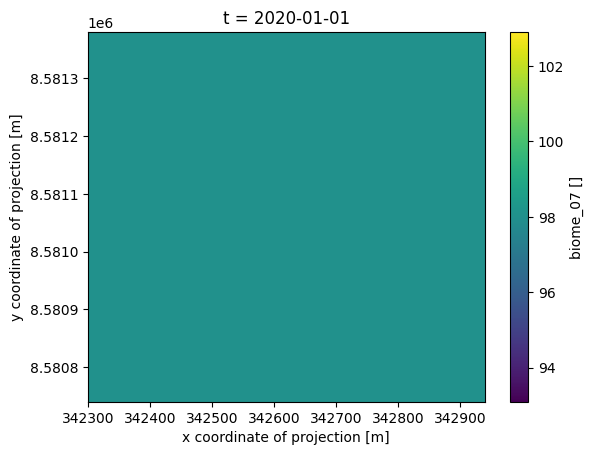

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

test = xr.open_dataset('C:\Git_projects\WAC\production\job_j-2412139b5dbc4c149abb4c342646df91\WAC_Extraction_patch_lat_-58_45017829591269_lon_-12_83145975719867.nc')

test['biome_07'].isel(t=0).plot()
plt.show()